## Long Short-Term Memory Recurrent Neural Network Model (LSTM RNN)
#### Credit to Aiden Curley for assistance

<a name="contents"></a>
- [Contents](#contents)  
    - [Imports](#imports)  
    - [Data Cleaning](#cleaning)  
    - [Preprocessing](#preprocess)  
    - [LSTM RNN Model on Title Only](#lstm)  
    - [Test on new Posts](#tests)     
    - [LSTM RNN Model Scores](#scores) 
    - [LSTM RNN Model Visuals](#visuals)  
    - [Conclusions](#conclusions)  
    - [Next Steps](#Next_Steps)  

<a name="imports"></a>
- [Back to Contents](#contents)
## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import nltk
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, LassoCV
nltk.download('stopwords')
from collections import Counter
import pickle
 

import tensorflow as tf

[nltk_data] Downloading package stopwords to /home/dlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a name="cleaning"></a>
- [Back to Contents](#contents)
    # Data Cleaning

In [2]:
df = pd.read_csv('./Data/tf_df.csv')
df.head()

,Unnamed: 0,subreddit,title,selftext,title_text_combined
0,0,Amd,Low VRAM Issues?,NaN,Low VRAM Issues?
1,1,Amd,[Level1Techs] 32 Core Threadripper Workstation...,NaN,[Level1Techs] 32 Core Threadripper Workstation...
2,2,Amd,Decent cheap AMD prebuilt systems? Canada,Trying to see if there's anything worth recomm...,Decent cheap AMD prebuilt systems? Canada Tryi...
3,3,Amd,The new drivers don't wanna download,I have been trying to update my drivers from t...,The new drivers don't wanna download I have be...
4,4,Amd,aorus redemption I on b550m,"last time, i said only gigabyte has not used d...","aorus redemption I on b550m last time, i said ..."


In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
df.head()

,subreddit,title,selftext,title_text_combined
0,Amd,Low VRAM Issues?,NaN,Low VRAM Issues?
1,Amd,[Level1Techs] 32 Core Threadripper Workstation...,NaN,[Level1Techs] 32 Core Threadripper Workstation...
2,Amd,Decent cheap AMD prebuilt systems? Canada,Trying to see if there's anything worth recomm...,Decent cheap AMD prebuilt systems? Canada Tryi...
3,Amd,The new drivers don't wanna download,I have been trying to update my drivers from t...,The new drivers don't wanna download I have be...
4,Amd,aorus redemption I on b550m,"last time, i said only gigabyte has not used d...","aorus redemption I on b550m last time, i said ..."


In [5]:
df.shape

(219480, 4)

In [6]:
# Clean the text function
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = re.sub(r'\d+', '', text) # This gets rid of the integers
    text = text.replace('x', '') # Credit - https://stackoverflow.com/questions/30315035/strip-numbers-from-string-in-python
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text
df['title'] = df['title'].apply(clean_text)


In [7]:
df['title'].head()

0                                      low vram issues
1    leveltechs core threadripper workstation upgra...
2             decent cheap amd prebuilt systems canada
3                      new drivers dont wanna download
4                                  aorus redemption bm
Name: title, dtype: object

In [8]:
# Vectorize the words and Create a common word dataframe
cvec = CountVectorizer()
cv_fit = cvec.fit_transform(df['title'])
word_list = cvec.get_feature_names();    
count_list = cv_fit.toarray().sum(axis=0)  
word_dict = dict(zip(word_list,count_list))
cleaned_df = pd.DataFrame(cv_fit.toarray(), columns= word_list)

counter = Counter()
counter.update(word_dict)
most_common = counter.most_common(20)
most_df = pd.DataFrame(most_common)

In [9]:
most_df

,0,1
0,pc,29556
1,ryzen,26697
2,build,26488
3,amd,19383
4,help,17940
5,first,13231
6,new,12771
7,gaming,11748
8,need,11540
9,cpu,10230


<a name="preprocess"></a>
- [Back to Contents](#contents)
# Preprocessing

In [10]:
# Credit to:- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# - https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500 # First 500 words in each title
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)  # instantiating Tokenizer
tokenizer.fit_on_texts(df['title'].values)  #fit text to values
word_index = tokenizer.word_index  # replaces every word with its weighted index
print('Found %s unique tokens.' % len(word_index))



Found 24109 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(df['title'].values) # adds index # of every word in a title
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)   # pads each post so every title has 500 length
print('Shape of data tensor:', X.shape)

Shape of data tensor: (219480, 500)


In [12]:
Y = pd.get_dummies(df['subreddit']).values  # 1 for Build Pc
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (219480, 2)


In [13]:
Y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print('Train')
print(X_train.shape,Y_train.shape)
print('='*40)
print('Test')
print(X_test.shape,Y_test.shape)

Train
(197532, 500) (197532, 2)
Test
(21948, 500) (21948, 2)


<a name="lstm"></a>
- [Back to Contents](#contents)
    # LSTM RNN Model 4a on Title Only

In [ ]:
# Keras Sequential Model:
# - https://keras.io/guides/sequential_model/

# Drop out:
# - https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
# - https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/#:~:text=Long%20Short%2DTerm%20Memory%20

# Softmax:
# - https://medium.com/analytics-vidhya/softmax-classifier-using-tensorflow-on-mnist-dataset-with-sample-code-6538d0783b84
# - https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d

# LSTM:
# - https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046
# - https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17 
# - https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21#:~:text=An%20LSTM%20has%20a%20similar,operations%20within%20the%20LSTM's%20cells.&text=These%20operations%20are%20used%20to,to%20keep%20or%20forget%20information. 

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001)])

In [16]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

686/686 [==============================] - 36s 53ms/step - loss: 0.3623 - accuracy: 0.8638
Test set
  Loss: 0.362
  Accuracy: 0.864


In [19]:
model.save('lstm_model1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: lstm_model1/assets


In [15]:
model = tf.keras.models.load_model('./lstm_model1/')


In [17]:
accr = model.evaluate(X_test,Y_test)

686/686 [==============================] - 35s 52ms/step - loss: 0.3623 - accuracy: 0.8638


<a name="visuals"></a>
- [Back to Contents](#contents)
  #  LSTM RNN Model Visuals

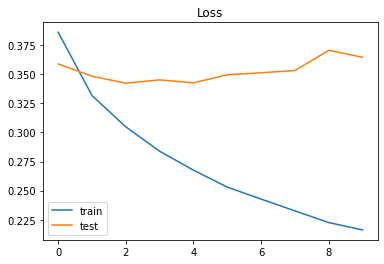

In [22]:
# Credit to: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# Model Loss plot
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

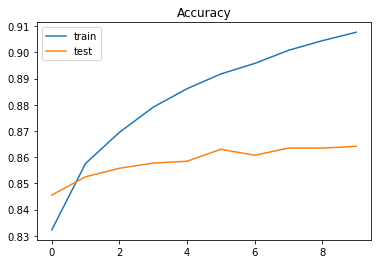

In [25]:
# Model Accuracy plot
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

<a name="lstm"></a>
- [Back to Contents](#contents)
    # LSTM RNN Model 4b on Title Only

In [15]:
# Increased Batchsize and lowered patience to lower overfitting
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=50, min_delta=0.0001)])

Epoch 1/10
695/695 [==============================] - 532s 766ms/step - loss: 0.4019 - accuracy: 0.8241 - val_loss: 0.3681 - val_accuracy: 0.8423
Epoch 2/10
695/695 [==============================] - 531s 765ms/step - loss: 0.3424 - accuracy: 0.8535 - val_loss: 0.3525 - val_accuracy: 0.8485
Epoch 3/10
695/695 [==============================] - 531s 764ms/step - loss: 0.3169 - accuracy: 0.8639 - val_loss: 0.3488 - val_accuracy: 0.8524
Epoch 4/10
695/695 [==============================] - 531s 764ms/step - loss: 0.2982 - accuracy: 0.8714 - val_loss: 0.3455 - val_accuracy: 0.8549
Epoch 5/10
695/695 [==============================] - 531s 764ms/step - loss: 0.2840 - accuracy: 0.8774 - val_loss: 0.3476 - val_accuracy: 0.8544
Epoch 6/10
695/695 [==============================] - 529s 761ms/step - loss: 0.2729 - accuracy: 0.8821 - val_loss: 0.3511 - val_accuracy: 0.8552
Epoch 7/10
695/695 [==============================] - 528s 759ms/step - loss: 0.2623 - accuracy: 0.8869 - val_loss: 0.3566 -

In [27]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

686/686 [==============================] - 35s 51ms/step - loss: 0.3660 - accuracy: 0.8613
Test set
  Loss: 0.366
  Accuracy: 0.861


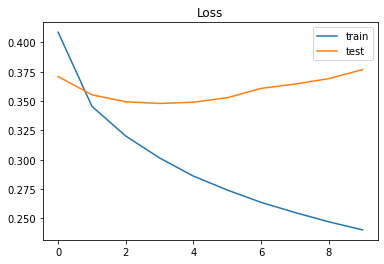

In [28]:
# Credit to: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# Model Loss plot
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

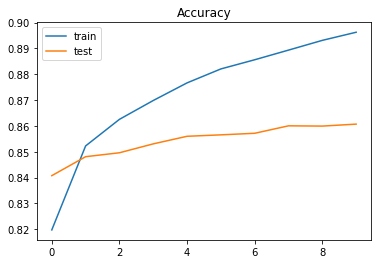

In [29]:
# Model Accuracy plot
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [30]:
# Increased Batchsize and lowered patience to lower overfitting
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=50, min_delta=0.0001)])

Epoch 1/10
695/695 [==============================] - 524s 754ms/step - loss: 0.4125 - accuracy: 0.8164 - val_loss: 0.3701 - val_accuracy: 0.8420
Epoch 2/10
695/695 [==============================] - 525s 755ms/step - loss: 0.3541 - accuracy: 0.8493 - val_loss: 0.3568 - val_accuracy: 0.8477
Epoch 3/10
695/695 [==============================] - 523s 752ms/step - loss: 0.3341 - accuracy: 0.8571 - val_loss: 0.3536 - val_accuracy: 0.8493
Epoch 4/10
695/695 [==============================] - 523s 753ms/step - loss: 0.3207 - accuracy: 0.8624 - val_loss: 0.3498 - val_accuracy: 0.8519
Epoch 5/10
695/695 [==============================] - 522s 751ms/step - loss: 0.3092 - accuracy: 0.8672 - val_loss: 0.3462 - val_accuracy: 0.8531
Epoch 6/10
695/695 [==============================] - 525s 755ms/step - loss: 0.2995 - accuracy: 0.8704 - val_loss: 0.3463 - val_accuracy: 0.8556
Epoch 7/10
695/695 [==============================] - 529s 761ms/step - loss: 0.2918 - accuracy: 0.8748 - val_loss: 0.3472 -

In [31]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

686/686 [==============================] - 35s 51ms/step - loss: 0.3448 - accuracy: 0.8604
Test set
  Loss: 0.345
  Accuracy: 0.860


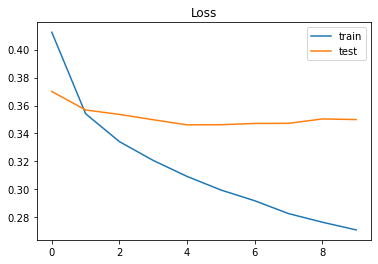

In [32]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

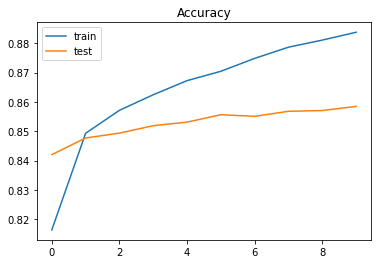

In [33]:
# Model Accuracy plot
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

<a name="tests"></a>
- [Back to Contents](#contents)
# Test on new Posts

In [18]:
# An AMD Post
# Source: https://www.reddit.com/r/Amd/comments/ii2mlv/radeon_driver_2083_vs_2014_2082_in_7_games_rx_570/
new_post = ['Radeon Driver 20.8.3 vs 20.1.4 - 20.8.2 in 7 games (RX 570) - With Microsoft Flight Simulator 2020']
seq = tokenizer.texts_to_sequences(new_post)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['AMD', 'Build a PC']
print(pred, labels[np.argmax(pred)])

[[0.98223555 0.01776442]] AMD


In [19]:
# A Build a PC Post
# Source: https://www.reddit.com/r/buildapc/comments/ihuxwa/im_a_bit_overwhelmed_with_the_many_different/
new_post = ['Im a bit overwhelmed with the many different graphics cards. Please help.']
seq = tokenizer.texts_to_sequences(new_post)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['AMD', 'Build a PC']
print(pred, labels[np.argmax(pred)])

[[0.00195413 0.9980458 ]] Build a PC


<a name="scores"></a>
- [Back to Contents](#contents)  
  #  LSTM RNN Model Scores

In [ ]:
# # LTSMRNN Model 1:  # Early stopping patience 3
# Epoch 1/5
# 3454/3454 [==============================] - 3054s 884ms/step - loss: 0.3696 - accuracy: 0.8407 - val_loss: 0.3384 - val_accuracy: 0.8545
# Epoch 2/5
# 3454/3454 [==============================] - 3064s 887ms/step - loss: 0.3146 - accuracy: 0.8656 - val_loss: 0.3204 - val_accuracy: 0.8631
# Epoch 3/5
# 3454/3454 [==============================] - 3050s 883ms/step - loss: 0.2860 - accuracy: 0.8785 - val_loss: 0.3054 - val_accuracy: 0.8706
# Epoch 4/5
# 3454/3454 [==============================] - 3057s 885ms/step - loss: 0.2647 - accuracy: 0.8871 - val_loss: 0.2960 - val_accuracy: 0.8750
# Epoch 5/5
# 3454/3454 [==============================] - 3052s 884ms/step - loss: 0.2465 - accuracy: 0.8951 - val_loss: 0.2929 - val_accuracy: 0.8795
# This model unfortunatly was overwritten before running on our test set.

# # LTSMRNN Model 2:  # Early stopping patience 100, Epoch 10/10, dropouts set to .2
# Epoch 1/10
# 2778/2778 [==============================] - 1213s 437ms/step - loss: 0.3861 - accuracy: 0.8323 - val_loss: 0.3589 - val_accuracy: 0.8456
# Epoch 2/10
# 2778/2778 [==============================] - 1209s 435ms/step - loss: 0.3318 - accuracy: 0.8576 - val_loss: 0.3483 - val_accuracy: 0.8525
# Epoch 3/10
# 2778/2778 [==============================] - 1212s 436ms/step - loss: 0.3048 - accuracy: 0.8695 - val_loss: 0.3423 - val_accuracy: 0.8558
# Epoch 4/10
# 2778/2778 [==============================] - 1215s 437ms/step - loss: 0.2838 - accuracy: 0.8791 - val_loss: 0.3452 - val_accuracy: 0.8578
# Epoch 5/10
# 2778/2778 [==============================] - 1219s 439ms/step - loss: 0.2676 - accuracy: 0.8861 - val_loss: 0.3426 - val_accuracy: 0.8585
# Epoch 6/10
# 2778/2778 [==============================] - 1208s 435ms/step - loss: 0.2530 - accuracy: 0.8917 - val_loss: 0.3496 - val_accuracy: 0.8630
# Epoch 7/10
# 2778/2778 [==============================] - 1207s 434ms/step - loss: 0.2427 - accuracy: 0.8958 - val_loss: 0.3513 - val_accuracy: 0.8607
# Epoch 8/10
# 2778/2778 [==============================] - 1207s 435ms/step - loss: 0.2326 - accuracy: 0.9008 - val_loss: 0.3533 - val_accuracy: 0.8635
# Epoch 9/10
# 2778/2778 [==============================] - 1209s 435ms/step - loss: 0.2225 - accuracy: 0.9044 - val_loss: 0.3706 - val_accuracy: 0.8635
# Epoch 10/10
# 2778/2778 [==============================] - 1207s 434ms/step - loss: 0.2162 - accuracy: 0.9076 - val_loss: 0.3646 - val_accuracy: 0.8641

# 686/686 [==============================] - 35s 51ms/step - loss: 0.3618 - accuracy: 0.8651
# Test set
#   Loss: 0.362
#   Accuracy: 0.865

# # LTSMRNN Model 3:  # Early stopping patience 100, Epoch 10/10, Dropouts set to .4
# Epoch 1/10
# 695/695 [==============================] - 524s 754ms/step - loss: 0.4125 - accuracy: 0.8164 - val_loss: 0.3701 - val_accuracy: 0.8420
# Epoch 2/10
# 695/695 [==============================] - 525s 755ms/step - loss: 0.3541 - accuracy: 0.8493 - val_loss: 0.3568 - val_accuracy: 0.8477
# Epoch 3/10
# 695/695 [==============================] - 523s 752ms/step - loss: 0.3341 - accuracy: 0.8571 - val_loss: 0.3536 - val_accuracy: 0.8493
# Epoch 4/10
# 695/695 [==============================] - 523s 753ms/step - loss: 0.3207 - accuracy: 0.8624 - val_loss: 0.3498 - val_accuracy: 0.8519
# Epoch 5/10
# 695/695 [==============================] - 522s 751ms/step - loss: 0.3092 - accuracy: 0.8672 - val_loss: 0.3462 - val_accuracy: 0.8531
# Epoch 6/10
# 695/695 [==============================] - 525s 755ms/step - loss: 0.2995 - accuracy: 0.8704 - val_loss: 0.3463 - val_accuracy: 0.8556
# Epoch 7/10
# 695/695 [==============================] - 529s 761ms/step - loss: 0.2918 - accuracy: 0.8748 - val_loss: 0.3472 - val_accuracy: 0.8551
# Epoch 8/10
# 695/695 [==============================] - 527s 759ms/step - loss: 0.2826 - accuracy: 0.8786 - val_loss: 0.3472 - val_accuracy: 0.8568
# Epoch 9/10
# 695/695 [==============================] - 529s 761ms/step - loss: 0.2765 - accuracy: 0.8811 - val_loss: 0.3504 - val_accuracy: 0.8570
# Epoch 10/10
# 695/695 [==============================] - 529s 761ms/step - loss: 0.2709 - accuracy: 0.8837 - val_loss: 0.3499 - val_accuracy: 0.8585

# 686/686 [==============================] - 35s 51ms/step - loss: 0.3448 - accuracy: 0.8604
# Test set
#   Loss: 0.345
#   Accuracy: 0.860



<a name="conclusions"></a>
- [Back to Contents](#contents)
  #  Conclusions



After successfully testing our model on predicting the Subreddits on unseen Reddit Titles correctly, we can determine that creating marketing and development strategies based on market sentiment is possible. By improving on the model, the possibilities of scraping several posts on various platforms on all computer manufacturers may  greatly benefit Intel on staying ahead of the technological curve, and regain dominance in the PC building market.

<a name="Next_Steps"></a>
- [Back to Contents](#contents)
  #  Next Steps

With more time, creating a model that can routinely scrape more data on several computer parts manufacturers is ideal.  Being able to see how our model performs with several outcomes may provide insights on improving on our model.

At the present state, I would include the contents with the titles to determine the increase in accuracy compared to my best Logistic Regression model.  

After rigorous training, we would test the improved version of the model on social networks such as Facebook to see how well it can capture relevant data where a title tag is not present.
